# Capstone Three: Predicting Taxi Trip Duration

Taxi trip durations in NYC can vary wildly because of several factors from weather and traffic to simply geography of the pickup and drop-off locations. For instance, New York is abounding with one-ways, side streets, and known for the ever-present number of pedestrians. With everyone engaging in a mad rush to get from point A to point B, you'll invariably find yourself late for whatever you need to be on time for. 

The goal of this analysis is to determine which factors predict the taxi trip's duration.

## Stakeholders & Audience

The main beneficiary will be the Taxi & Limousine Commission of NYC. They’ll better be able to control costs and maintain a level of accuracy relating to ‘appropriate’ travel times for taxi drivers. 

Another group that will benefit are passengers that will be better able to know how long trips will take, ahead of time.

In [15]:
# Loading standard library packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading packages to work with dates

from datetime import datetime

# Loading packages for ml

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.metrics import mean_squared_error

## Data

The main data stems from the 2016 NYC Yellow Cab trip record data from Big Query on the Google Cloud Platform.

Two main datasets will be used for this project:

- taxi_train
- taxi_test

**taxi_train**

Each row corresponds to a specific taxi trip with features detailing pickup & drop off times, passenger count and other variables. It consists of 1,458,644 observations and 11 variables, provided via [Kaggle](https://www.kaggle.com/c/nyc-taxi-trip-duration/data?select=train.zip). The target variable is named 'trip_duration' and it indicates the length of a taxi trip. Data is 81 MB compressed and available as a single zip file.

**taxi_test**

Similar to the Taxi_Train dataset, each row is associated with a trip. This dataset consists of 625,134 observations and 10 variables. Data is 21 MB compressed and available as a single zip file from [Kaggle](https://www.kaggle.com/c/nyc-taxi-trip-duration/data?select=test.zip). We will be predicting the ‘trip_duration’ variable for this dataset.

In [2]:
# Importing data using Kaggle API

!kaggle competitions download -c nyc-taxi-trip-duration -p ../data/raw -q

In [3]:
# Unzipping dataset files

!unzip ../data/raw/nyc-taxi-trip-duration.zip -d ../data/raw
!unzip ../data/raw/train.zip -d ../data/raw
!unzip ../data/raw/test.zip -d ../data/raw

Archive:  ../data/raw/nyc-taxi-trip-duration.zip
  inflating: ../data/raw/sample_submission.zip  
  inflating: ../data/raw/test.zip    
  inflating: ../data/raw/train.zip   
Archive:  ../data/raw/train.zip
  inflating: ../data/raw/train.csv   
Archive:  ../data/raw/test.zip
  inflating: ../data/raw/test.csv    


In [2]:
# Loading the data

taxi_train = pd.read_csv('../data/raw/train.csv')
taxi_test = pd.read_csv('../data/raw/test.csv')

### Initial Investigations of the Data

Looking at the structure of the data, while noting any outliers or things that look... off.

In [6]:
taxi_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


**Data Fields Info**

 - *id*: a unique identifier for each trip
 - *vendor_id* - a code indicating the provider associated with the trip record
 - *pickup_datetime* - date and time when the meter was engaged
 - *dropoff_datetime* - date and time when the meter was disengaged
 - *passenger_count* - the number of passengers in the vehicle (driver entered value)
 - *pickup_longitude* - the longitude where the meter was engaged
 - *pickup_latitude* - the latitude where the meter was engaged
 - *dropoff_longitude* - the longitude where the meter was disengaged
 - *dropoff_latitude* - the latitude where the meter was disengaged
 - *store_and_fwd_flag* - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server
  - Y = store and forward
  - N = not a store and forward trip
 - *trip_duration* - duration of the trip in seconds

In [7]:
taxi_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


A **few** things seem off here:
 - *passenger_count*: 
  - there should probably only be a minimum of 1, unless there're some erroneous trips in the dataset
 - *trip_duration*:
  - the minimum looks like 1, which is definitely not a trip worth analyzing
  - the maximum is 3,526,282 seconds which a back of the envelop calculations means it was a 979.52-hour trip!

Some outliers need to be cleaned up here, in a bit.

In [8]:
taxi_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Doesn't look like we have to worry about null values with this dataset.

## Data Wrangling & Preparation

Here we'll address some of the issues with the data and get it ready for analysis.

**First** on the docket is formatting the *pickup_datetime* & *dropoff_datetime* so that we can summarize it based on days of the week or across months to determine any seasonality.

**Next** I'll get the trip duration to address the outliers, by excluding information that's 2+ standard deviations away.

**Also** the latitudes and longitudes need to be verified that they're within NYC's parameters. Specifically, according to NYC's [Open Data Portal](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm):
 - longitudinal boundaries of NYC are between -74.03 and -73.75
 - latitudinal boundaries of NYC are between 40.63 and 40.85


In [9]:
# Coverting datetimes to dates

taxi_train.pickup_datetime = pd.to_datetime(taxi_train.pickup_datetime)
taxi_test.pickup_datetime = pd.to_datetime(taxi_test.pickup_datetime)

taxi_train.loc[:, 'pickup_date'] = taxi_train.pickup_datetime.dt.date
taxi_test.loc[:, 'pickup_date'] = taxi_test.pickup_datetime.dt.date

taxi_train.dropoff_datetime = pd.to_datetime(taxi_train.dropoff_datetime)

In [10]:
# Trip durations within 2 standard deviations from the mean

mean = taxi_train.trip_duration.mean()
std = taxi_train.trip_duration.std()

taxi_train = taxi_train[taxi_train.trip_duration <= (mean + 2 * std)]
taxi_train = taxi_train[taxi_train.trip_duration >= (mean - 2 * std)]

In [11]:
# Limiting the dataset to the longitudinal & latitudinal borders of NYC

taxi_train = taxi_train[taxi_train.pickup_longitude <= -73.75]
taxi_train = taxi_train[taxi_train.pickup_longitude >= -74.03]
taxi_train = taxi_train[taxi_train.pickup_latitude <= 40.85]
taxi_train = taxi_train[taxi_train.pickup_latitude >= 40.63]

taxi_train = taxi_train[taxi_train.dropoff_longitude <= -73.75]
taxi_train = taxi_train[taxi_train.dropoff_longitude >= -74.03]
taxi_train = taxi_train[taxi_train.dropoff_latitude <= 40.85]
taxi_train = taxi_train[taxi_train.dropoff_latitude >= 40.63]

In [12]:
taxi_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.437128e+06,1.437128e+06,1.437128e+06,1.437128e+06,1.437128e+06,1.437128e+06,1.437128e+06
mean,1.534289e+00,1.664175e+00,-7.397381e+01,4.075104e+01,-7.397356e+01,4.075165e+01,8.244279e+02
std,4.988230e-01,1.314200e+00,3.719130e-02,2.746487e-02,3.262917e-02,2.966544e-02,6.446899e+02
min,1.000000e+00,0.000000e+00,-7.402995e+01,4.063000e+01,-7.403000e+01,4.063000e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073748e+01,-7.399129e+01,4.073626e+01,3.940000e+02
50%,2.000000e+00,1.000000e+00,-7.398177e+01,4.075412e+01,-7.397986e+01,4.075451e+01,6.550000e+02
75%,2.000000e+00,2.000000e+00,-7.396751e+01,4.076832e+01,-7.396349e+01,4.076952e+01,1.056000e+03
max,2.000000e+00,6.000000e+00,-7.375066e+01,4.085000e+01,-7.375000e+01,4.085000e+01,1.141100e+04


This is looking in much better shape for visualizations and actual analysis!

In [14]:
# Saving cleansed datasets

taxi_train.to_csv('../data/interim/taxi_train.csv')
taxi_test.to_csv('../data/interim/taxi_test.csv')

# Compressing cleansed datasets

!zip -r -X ../data/interim/taxi_train.zip ../data/interim/taxi_train.csv
!zip -r -X ../data/interim/taxi_test.zip ../data/interim/taxi_test.csv

updating: ../data/interim/taxi_train.csv (deflated 67%)
updating: ../data/interim/taxi_test.csv (deflated 70%)


## Exploratory Data Analysis

Here, we'll develop visualizations and tease out some analyses of interest.

### Trip Duration

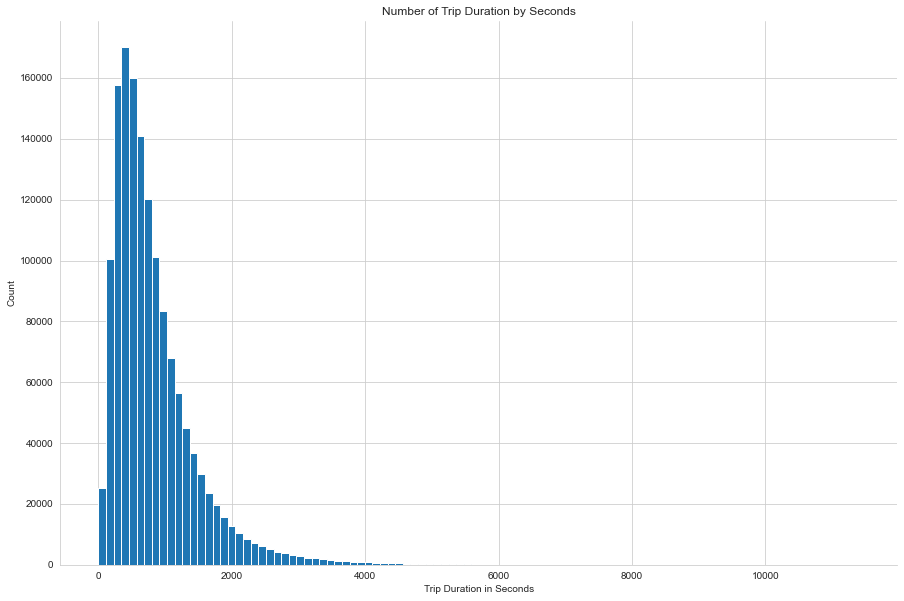

In [36]:
# Histogram of trip_duration

sns.set_style("whitegrid")
fig = plt.figure(figsize = (15,10))

taxi_train.trip_duration.hist(bins = 100)
plt.title('Number of Trip Duration by Seconds')
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Count')

sns.despine()

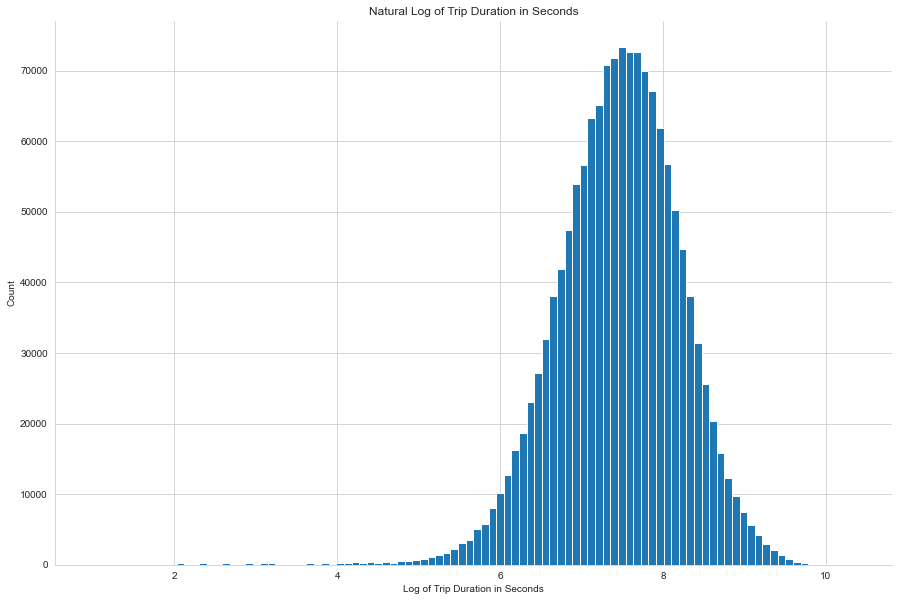

In [55]:
# Experimenting with a log scale to account for the sheer size of the dataset

taxi_train['nat_log_trip_duration'] = np.log(taxi_train.trip_duration) + 1

fig  = plt.figure(figsize = (15,10))

taxi_train.nat_log_trip_duration.hist(bins = 100)
plt.title('Natural Log of Trip Duration in Seconds')
plt.xlabel('Log of Trip Duration in Seconds')
plt.ylabel('Count')

sns.despine()

### Pickup Dates & Seasonality

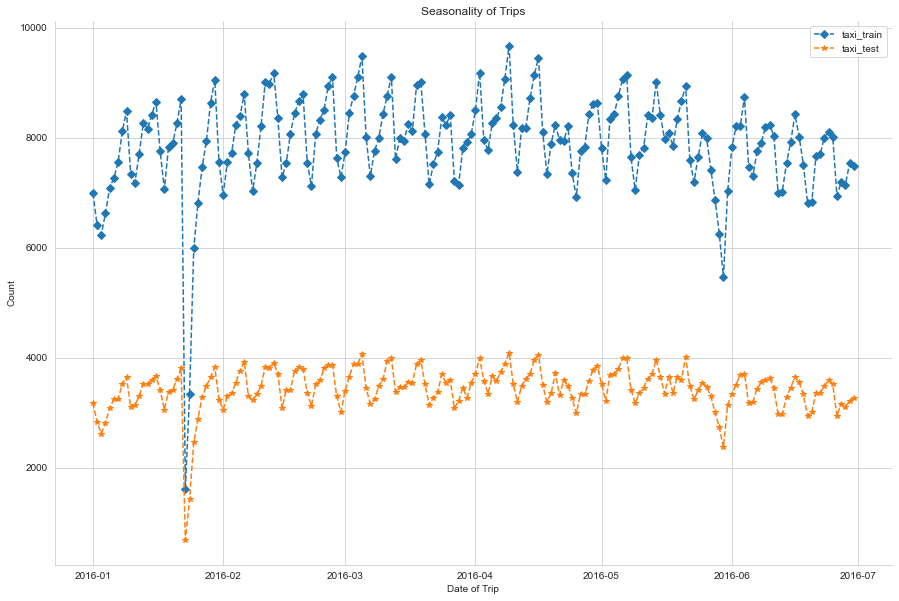

In [71]:
# Investigating the pickup_date to determine any seasonality in the trips

fig = plt.figure(figsize = (15,10))

taxi_train.groupby('pickup_date').count()['id'].plot(label = 'taxi_train', marker = 'D', ls = '--')
taxi_test.groupby('pickup_date').count()['id'].plot(label = 'taxi_test', marker = '*', ls = '--')

plt.title('Seasonality of Trips')
plt.xlabel('Date of Trip')
plt.ylabel('Count')
plt.legend(loc=0)

sns.despine()

Thankfully, the taxi_train & taxi_test datasets have a similar trend/shape. 

Looks like there's quite the dip in trips in late **January**, with another modest dip in late **May**. My initial guesses are around data errors versus anything season (winter in January or Spring in May) related. Outliers!

### Vendor Differentiation

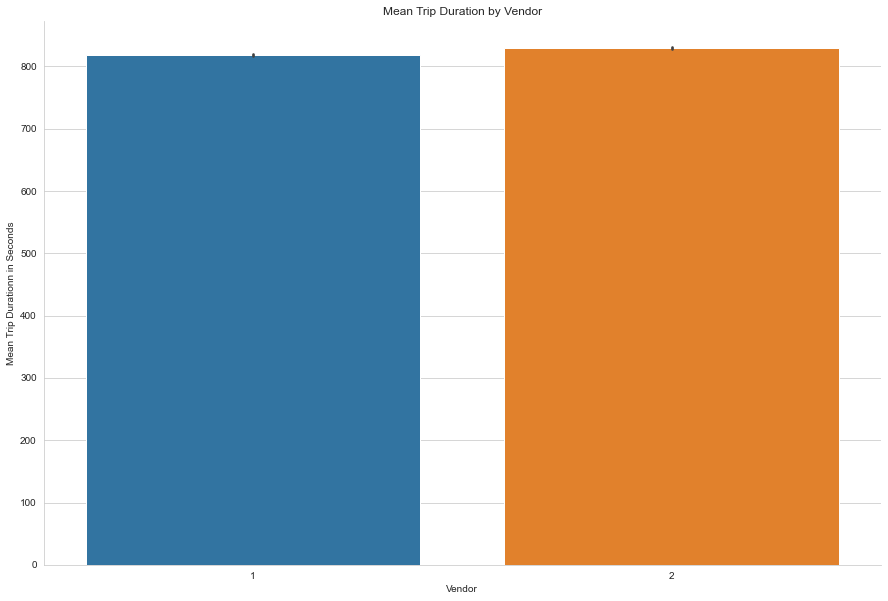

In [88]:
# Looking at the two taxi vendors now

fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'vendor_id', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

It looks like there **isn't much of a difference** in the mean trip durations between vendors. However, let's see if there's something else that can help tease apart trup durations.

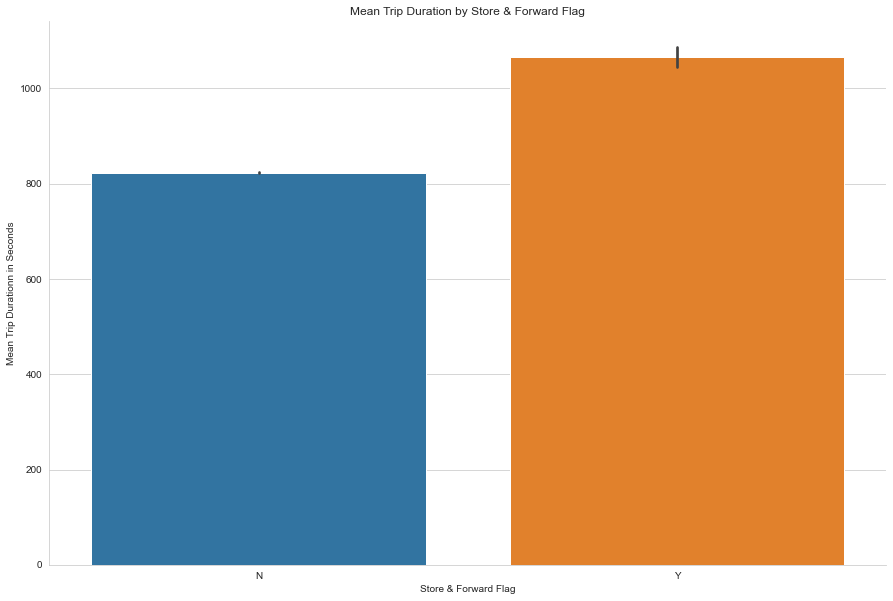

In [89]:
# Looking at the store_and_fwd_flag for a difference among trip durations

fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Store & Forward Flag')
plt.xlabel('Store & Forward Flag')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

Oooh... there looks to be **some differentiation** between the Store & Forward Flag and mean Trip Duration! This may indicate inaccuracies in how the trips were recorded given the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server.

Let's look at the number of passengers as this may mean that Trip Duration may be longer for more passengers as they'll need to be dropped off in multiple locations. To test that theory, let's see how passengers looks when bumped up against trip duration.

### Passenger Counts

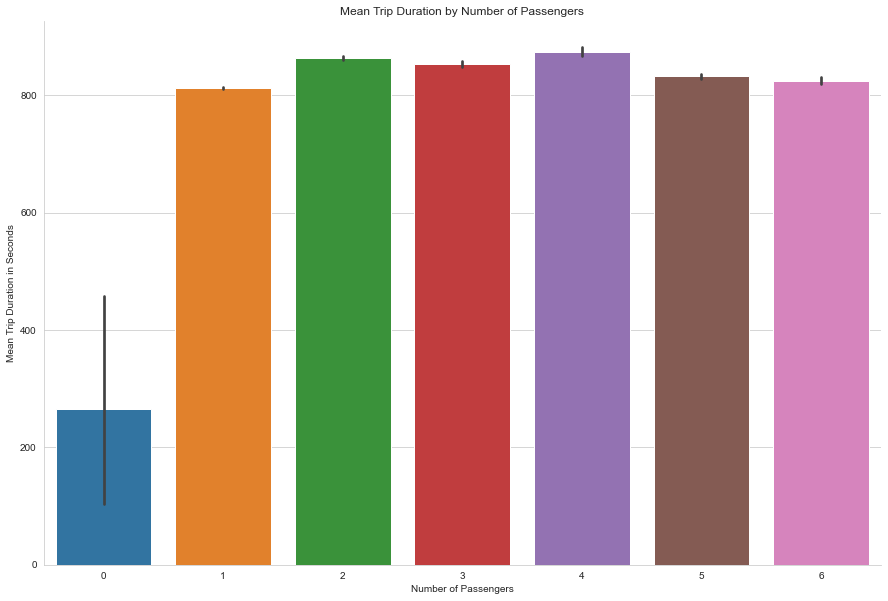

In [90]:
# Looking at passengers against mean travel time

fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'passenger_count', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

Hm... it looks like there's **some consistency/no difference** across the number of passengers (>= 1) in terms of mean travel time. There's might be a data issue relating to the '0' passenger count, but I'll investigate if the test data has the same issue.

In [92]:
print(taxi_train.passenger_count.value_counts())
taxi_test.passenger_count.value_counts()

1    1018715
2     206864
5      76912
3      58989
6      47639
4      27957
0         52
Name: passenger_count, dtype: int64


1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64

I guess there really **isn't that much of a difference**, so I wont need to address the '0' passenger_count.

### Pickup Locations

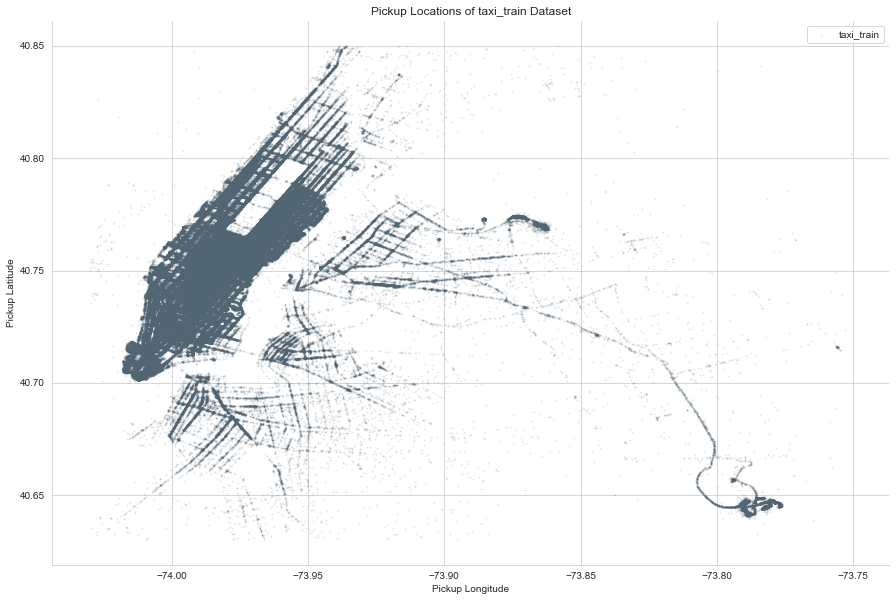

In [112]:
# Looking at difference of pickup locations between the train and test datasets

fig = plt.figure(figsize = (15,10))

plt.scatter(taxi_train.pickup_longitude, taxi_train.pickup_latitude, s = 1, 
            label = 'taxi_train', alpha = 0.1, color = 'xkcd:slate')

plt.title('Pickup Locations of taxi_train Dataset')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')

plt.legend(loc = 0)

sns.despine()

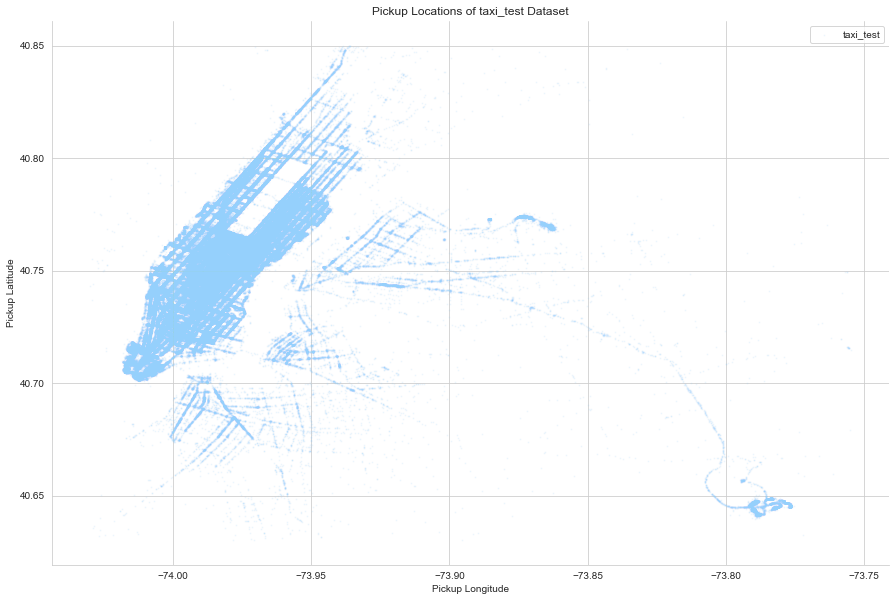

In [111]:
#Applying the same NYC longitudinal and latitudinal border contraints as the taxi_train dataset

taxi_test = taxi_test[taxi_test.pickup_longitude <= -73.75]
taxi_test = taxi_test[taxi_test.pickup_longitude >= -74.03]
taxi_test = taxi_test[taxi_test.pickup_latitude <= 40.85]
taxi_test = taxi_test[taxi_test.pickup_latitude >= 40.63]

taxi_test = taxi_test[taxi_test.dropoff_longitude <= -73.75]
taxi_test = taxi_test[taxi_test.dropoff_longitude >= -74.03]
taxi_test = taxi_test[taxi_test.dropoff_latitude <= 40.85]
taxi_test = taxi_test[taxi_test.dropoff_latitude >= 40.63]

fig = plt.figure(figsize = (15,10))

plt.scatter(taxi_test.pickup_longitude, taxi_test.pickup_latitude, s = 1, 
                          label = 'taxi_test', alpha = 0.1, color = 'xkcd:light blue')

plt.title('Pickup Locations of taxi_test Dataset')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')

plt.legend(loc = 0)

sns.despine()

It looks like they're **near identical** regarding the pickup locations!

### Dates

Currently, the *pickup_datetime* and *dropoff_datetime* aren't granular enough to work with, and definitely not ready for modeling in its categorical state.

Here, we'll beging extracting more granular dates.

In [134]:
# Creating day_of_week variable for both taxi_train & taxi_test

taxi_train['day_of_week'] = taxi_train.pickup_datetime.dt.dayofweek
taxi_test['day_of_week'] = taxi_test.pickup_datetime.dt.dayofweek

taxi_train.day_of_week.value_counts().size, taxi_test.day_of_week.value_counts().size

(7, 7)

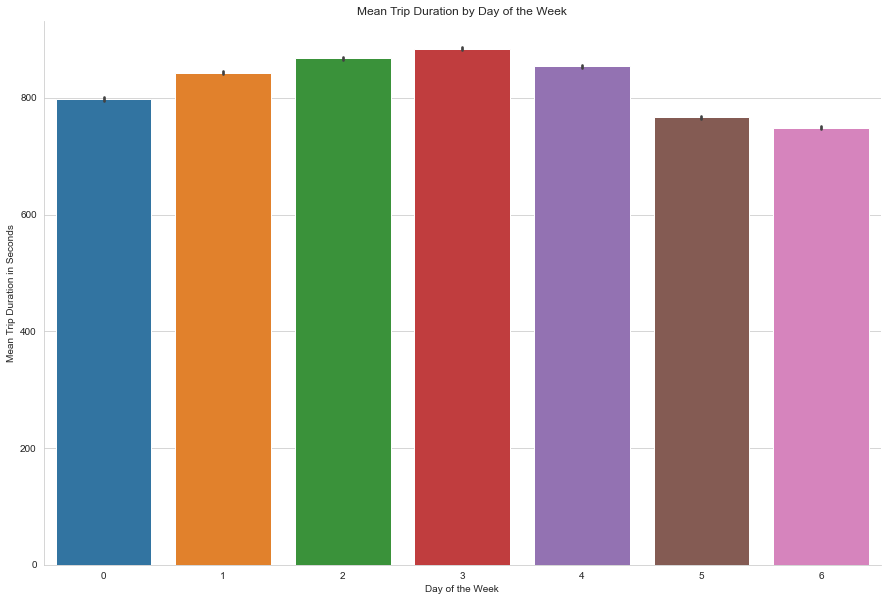

In [136]:
fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'day_of_week', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

In [130]:
# Creating month variable for both taxi_train & taxi_test

taxi_train['month'] = taxi_train.pickup_datetime.dt.month
taxi_test['month'] = taxi_test.pickup_datetime.dt.month

taxi_train.month.value_counts().size, taxi_test.month.value_counts().size

(6, 6)

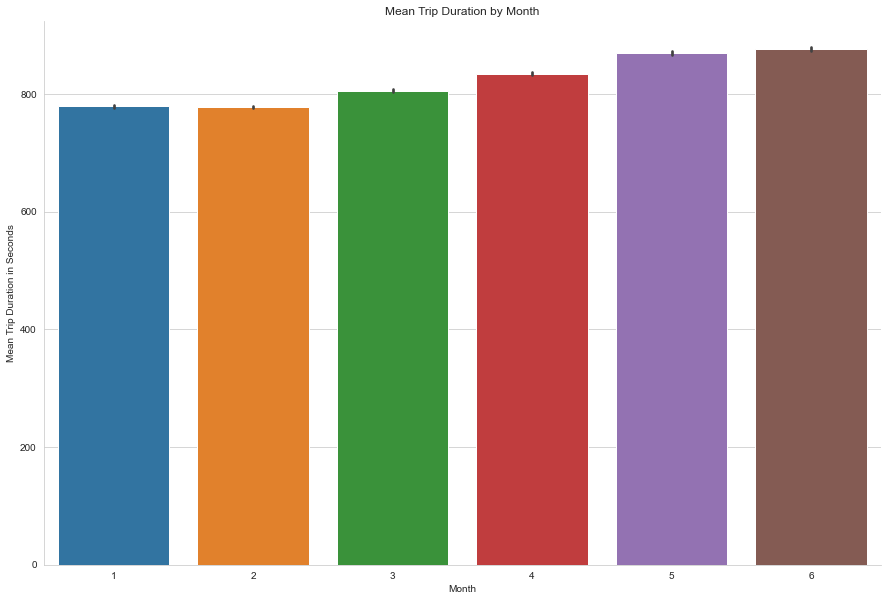

In [137]:
fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'month', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Month')
plt.xlabel('Month')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

In [126]:
# Creating day_of_month variable for both taxi_train & taxi_test

taxi_train['day_of_month'] = taxi_train.pickup_datetime.dt.day
taxi_test['day_of_month'] = taxi_test.pickup_datetime.dt.day

len(taxi_train.day_of_month.value_counts()), len(taxi_test.day_of_month.value_counts())

(31, 31)

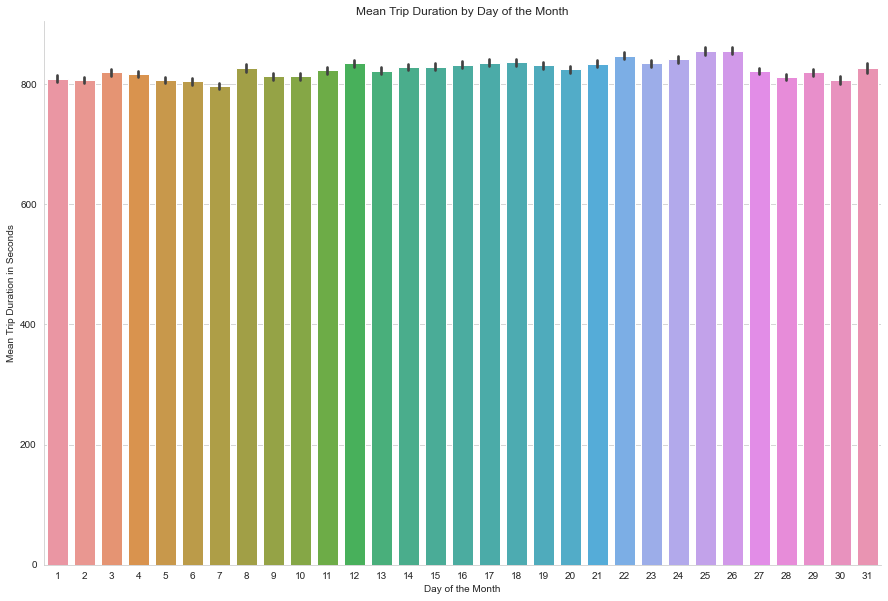

In [138]:
fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'day_of_month', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

In [133]:
# Creating hour variable for both taxi_train & taxi_test

taxi_train['hour'] = taxi_train.pickup_datetime.dt.hour
taxi_test['hour'] = taxi_test.pickup_datetime.dt.hour

taxi_train.hour.value_counts().size, taxi_test.hour.value_counts().size

(24, 24)

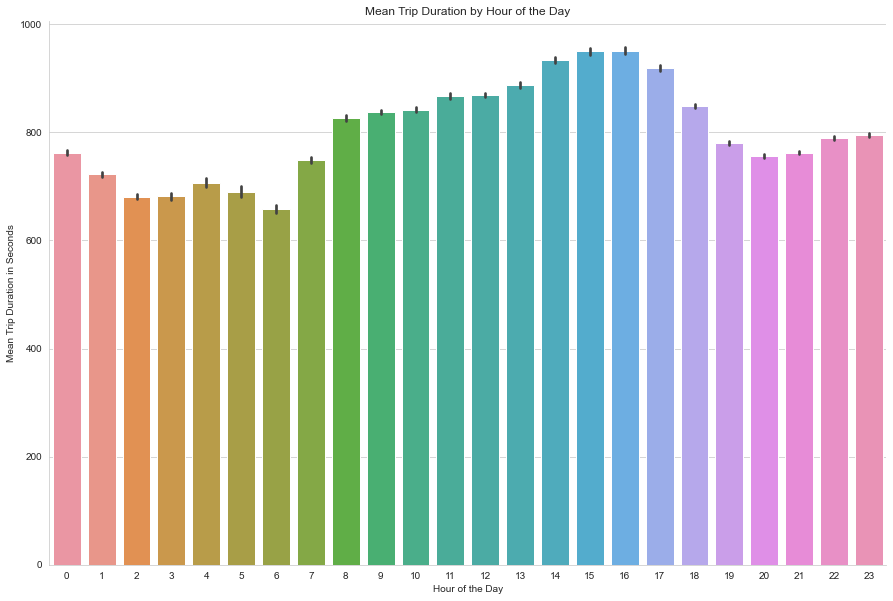

In [139]:
fig = plt.figure(figsize = (15,10))

sns.barplot(x = 'hour', y = 'trip_duration', data = taxi_train)
plt.title('Mean Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Trip Duration in Seconds')

sns.despine()

Great! So it looks like both taxi_train & taxi_test have, 7 days in a week, 6 months, 31 days in a month and 24 hours in a day.

It's pretty interesting **how much consistency** there is in mean *trip_duration* amongst all the date variables... **except for hour of the day**. It makes sense that *trip_duration* during typical working hours of 8a - 5p are longer. The assumption is that there're more people on the road, commuting and generally creating traffic.

<AxesSubplot:>

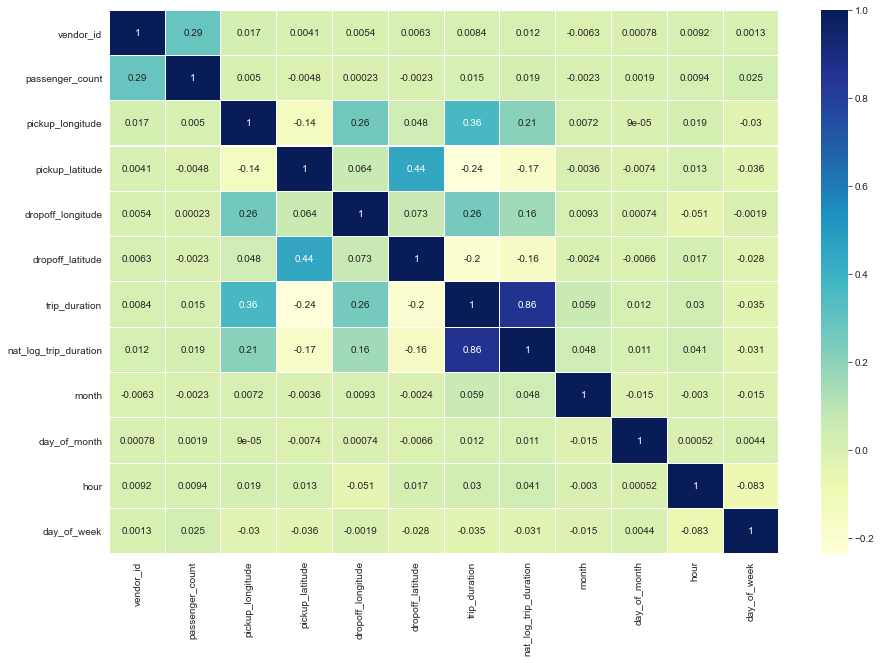

In [143]:
# Initial heatmap of variables

fig = plt.figure(figsize = (15,10))

sns.heatmap(taxi_train.corr(), linewidths=.1, cmap="YlGnBu", annot=True)

Hm... I'm not seeing anything that has a strong correlation with trip_duration, but there's a little indication between *pickup_longitude/latitude* & *dropoff_longitude/latitude*. 

This, of course, makes sense that a closer dropoff location means a shorter trip, in general. So nothing really gained from the heatmap, bummer.

In [73]:
# Saving cleansed datasets

taxi_train.to_csv('../data/interim/taxi_train.csv', index = False)
taxi_test.to_csv('../data/interim/taxi_test.csv', index = False)

# Compressing cleansed datasets

!zip -r -X ../data/interim/taxi_train.zip ../data/interim/taxi_train.csv
!zip -r -X ../data/interim/taxi_test.zip ../data/interim/taxi_test.csv

updating: ../data/interim/taxi_train.csv (deflated 58%)
updating: ../data/interim/taxi_test.csv (deflated 64%)


## Feature Engineering & Dummy Coding

One potential avenue of analysis will be to look at the speed the particular taxi is travelling at while traversing NYC. In order to calculate speed we need to determine distance in order to compare the time it takes to traverse that distance.

Thankfully, in the dataset we have longitudinal and latitudinal data. Using information from a preexistin [Kernel](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367) on Kaggle, the following functions calculate distance of a specific trip based on the pickup and dropoff latitudinal & longitudinal data.

In [1]:
# Haversine distance is great-circle distance between two points on a sphere using latitude & longitude

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# Now we can calculate the summed distance traveled in Manhattan

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

# Lastly, we calculate the bearing of the distance traveled. 

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

We then use these functions on both the *taxi_train* & *taxi_test* datasets!

In [21]:
taxi_train['distance_haversine'] = haversine_array(taxi_train.pickup_latitude.values, 
                                                  taxi_train.pickup_longitude.values, 
                                                  taxi_train.dropoff_latitude.values, 
                                                  taxi_train.dropoff_longitude.values)

taxi_test['distance_haversine'] = haversine_array(taxi_test.pickup_latitude.values, 
                                                 taxi_test.pickup_longitude.values, 
                                                 taxi_test.dropoff_latitude.values, 
                                                 taxi_test.dropoff_longitude.values)    
    
taxi_train['distance_dummy_manhattan'] = dummy_manhattan_distance(taxi_train.pickup_latitude.values, 
                                                                 taxi_train.pickup_longitude.values, 
                                                                 taxi_train.dropoff_latitude.values, 
                                                                 taxi_train.dropoff_longitude.values)

taxi_test['distance_dummy_manhattan'] =  dummy_manhattan_distance(taxi_test.pickup_latitude.values, 
                                                                    taxi_test.pickup_longitude.values, 
                                                                    taxi_test.dropoff_latitude.values, 
                                                                    taxi_test.dropoff_longitude.values)

taxi_train['direction'] = bearing_array(taxi_train.pickup_latitude.values, 
                                          taxi_train.pickup_longitude.values, 
                                          taxi_train.dropoff_latitude.values, 
                                          taxi_train.dropoff_longitude.values)

taxi_test['direction'] = bearing_array(taxi_test.pickup_latitude.values, 
                                         taxi_test.pickup_longitude.values, 
                                         taxi_test.dropoff_latitude.values, 
                                         taxi_test.dropoff_longitude.values)

With the distance figured out, we can start looking at how to calculate speed (distance / time). Here, we'll zero-in on the hour of the day, the day of the week, and the month comapred against average speed.

In [23]:
taxi_train['avg_speed_h'] = 1000 * (taxi_train.distance_haversine / taxi_train.trip_duration)
taxi_train['avg_speed_m'] = 1000 * (taxi_train.distance_dummy_manhattan / taxi_train.trip_duration)

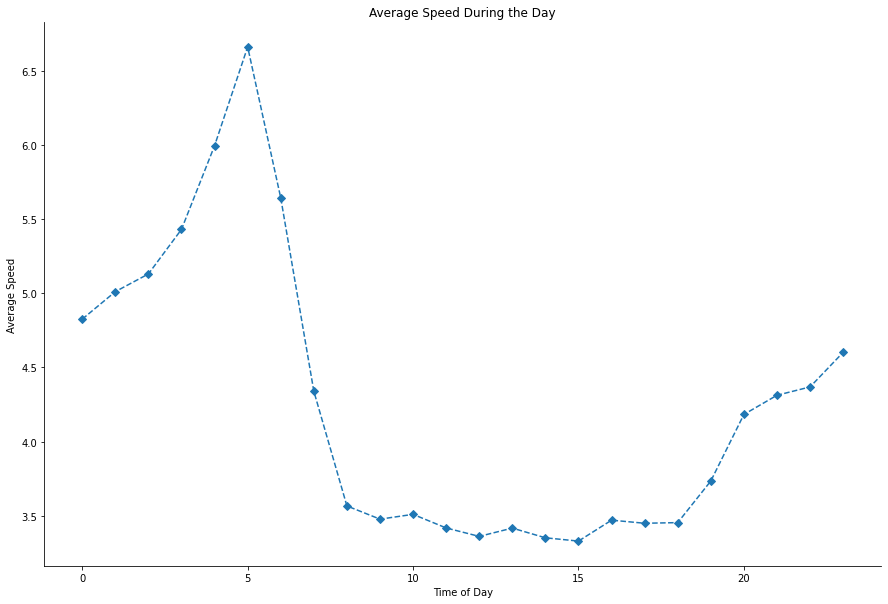

In [29]:
# Let's plot this to see if any patterns exist with the time of day and speed

fig = plt.figure(figsize = (15,10))

taxi_train.groupby('hour').mean()['avg_speed_h'].plot(marker = 'D', ls = '--')

plt.title('Average Speed During the Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Speed')

sns.despine()

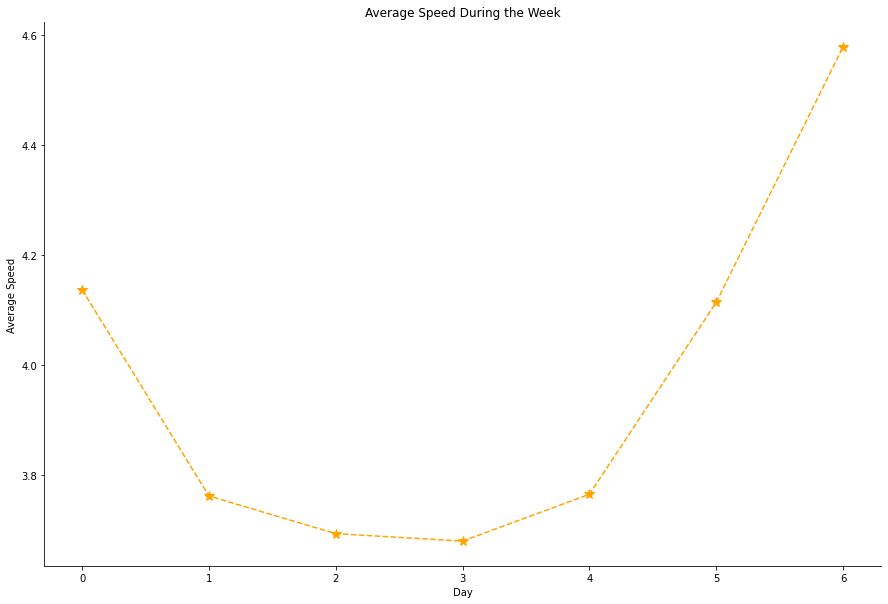

In [44]:
# Looking for patterns between day of the week and average speed

fig = plt.figure(figsize = (15,10))

taxi_train.groupby('day_of_week').mean()['avg_speed_h'].plot(color = 'orange', marker = '*', ms = 10, ls = '--')

plt.title('Average Speed During the Week')
plt.xlabel('Day')
plt.ylabel('Average Speed')

sns.despine()

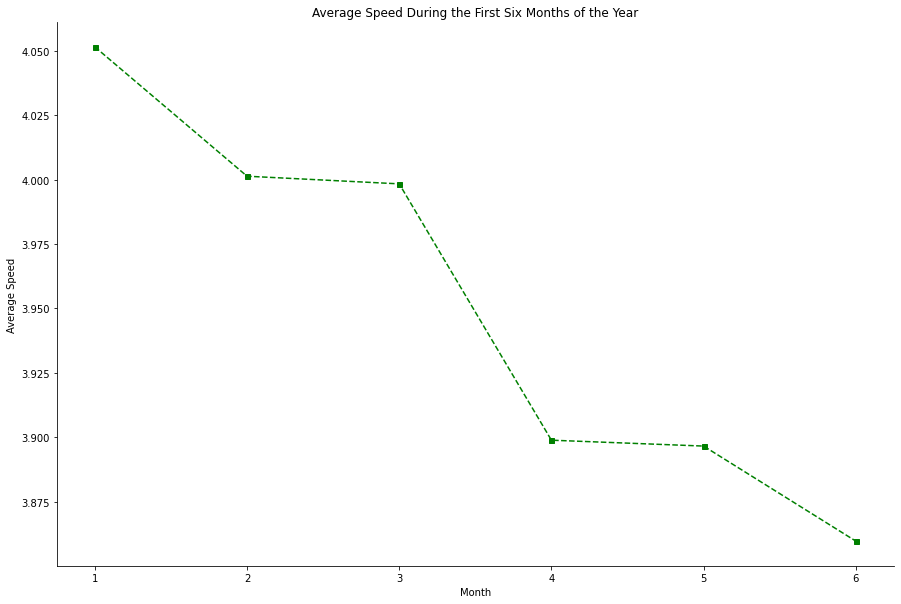

In [46]:
# Looking for patterns between the month when the taxi occurred and average speed

fig = plt.figure(figsize = (15,10))

taxi_train.groupby('month').mean()['avg_speed_h'].plot(color = 'green', marker = 's', ms = 5, ls = '--')

plt.title('Average Speed During the First Six Months of the Year')
plt.xlabel('Month')
plt.ylabel('Average Speed')

sns.despine()

**Initial Findings**
- During the day: typical work hours of 8a - 5p have the lowest avergae speed of taxi trip
- During the week: Monday - Thursday have the lowest average speed of taxi trip
- During the year: warmer months have lower average speed

This makes sense given the weather can heavily factor into how much time one is outdoors, where the colder, earlier hours of the day have less people, and in turn less traffis. Less traffic, intuitively, means there's more of an opportunity to travel faster, speed-wise.

### Dummy Coding

Here we want to be able to handle the object/non-numeric variables that can trip up our model.

In [50]:
# taxi_train

vendor_train = pd.get_dummies(taxi_train.vendor_id, prefix = 'vi', prefix_sep = '_')
month_train = pd.get_dummies(taxi_train.month, prefix = 'm', prefix_sep = '_')
passenger_count_train = pd.get_dummies(taxi_train.passenger_count, prefix = 'pc', prefix_sep = '_')
dom_train = pd.get_dummies(taxi_train.day_of_month, prefix = 'dom', prefix_sep = '_')
store_and_fwd_flag_train = pd.get_dummies(taxi_train.store_and_fwd_flag, prefix = 'sf', prefix_sep = '_')
hour_train = pd.get_dummies(taxi_train.hour, prefix = 'h', prefix_sep = '_')
dow_train = pd.get_dummies(taxi_train.day_of_week, prefix = 'dow', prefix_sep = '_')

# taxi_test

vendor_test = pd.get_dummies(taxi_test.vendor_id, prefix = 'vi', prefix_sep = '_')
passenger_count_test = pd.get_dummies(taxi_test.passenger_count, prefix = 'pc', prefix_sep = '_')
month_test = pd.get_dummies(taxi_test.month, prefix = 'm', prefix_sep = '_')
store_and_fwd_flag_test = pd.get_dummies(taxi_test.store_and_fwd_flag, prefix = 'sf', prefix_sep = '_')
dom_test = pd.get_dummies(taxi_test.day_of_month, prefix = 'dom', prefix_sep = '_')
hour_test = pd.get_dummies(taxi_test.hour, prefix = 'h', prefix_sep = '_')
dow_test = pd.get_dummies(taxi_test.day_of_week, prefix = 'dow', prefix_sep = '_')

In [52]:
# Checking vendor datasets

vendor_train.shape, vendor_test.shape

((1437128, 2), (616934, 2))

In [56]:
# Checking hour datasets

hour_train.shape, hour_test.shape

((1437128, 24), (616934, 24))

In [58]:
# Checking day of week datasets

dow_train.shape, dow_test.shape

((1437128, 7), (616934, 7))

In [53]:
# Checking month datasets

month_train.shape, month_test.shape

((1437128, 6), (616934, 6))

In [57]:
# Checking day of month datasets

dom_train.shape,dom_test.shape

((1437128, 31), (616934, 31))

In [54]:
# Checking passenger count datasets

passenger_count_train.shape, passenger_count_test.shape

((1437128, 7), (616934, 8))

There were two trips with 9 passengers in taxi_test where taxi_train had no trips with 9 passengers.

In [59]:
# Cleaning up outlier passenger count from taxi_test

passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)
passenger_count_test.shape

(616934, 7)

In [55]:
# Checking store and forward flag datasets

store_and_fwd_flag_train.shape, store_and_fwd_flag_test.shape

((1437128, 2), (616934, 2))

Now let's clean up the *taxi_train* and *taxi_test* datasets a bit to create the final versions.

In [62]:
processed_train = taxi_train.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'month', 
                                   'day_of_month', 'hour', 'day_of_week', 'pickup_longitude', 'pickup_latitude', 
                                   'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime', 'dropoff_datetime', 
                                   'pickup_date', 'avg_speed_h', 'avg_speed_m', 'trip_duration'], axis = 1)
test_id = taxi_test.id

processed_test = taxi_test.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'month', 
                                 'day_of_month', 'hour', 'day_of_week', 'pickup_longitude', 'pickup_latitude', 
                                 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime', 'pickup_date'], 
                                axis = 1)

In [64]:
# Checking datasets after cleaning

processed_train.shape, processed_test.shape

((1437128, 4), (616934, 3))

In [66]:
# Saving cleansed datasets

processed_train.to_csv('../data/processed/processed_train.csv', index = False)
processed_test.to_csv('../data/processed/processed_test.csv', index = False)

# Compressing cleansed datasets

!zip -r -X ../data/processed/processed_train.zip ../data/processed/processed_train.csv
!zip -r -X ../data/processed/processed_test.zip ../data/processed/processed_test.csv

updating: ../data/processed/processed_train.csv (deflated 54%)
  adding: ../data/processed/processed_test.csv (deflated 52%)


In [70]:
# Now to create the final versions of the datasets

taxi_train_master = pd.concat([processed_train, vendor_train, passenger_count_train, store_and_fwd_flag_train, 
                          month_train, dom_train, hour_train, dow_train], axis=1)

taxi_test_master = pd.concat([processed_test, vendor_test, passenger_count_test, store_and_fwd_flag_test, 
                              month_test, dom_test, hour_test, dow_test], axis=1)

In [71]:
# Saving final datasets

taxi_train_master.to_csv('../data/processed/taxi_train_master.csv', index = False)
taxi_test_master.to_csv('../data/processed/taxi_test_master.csv', index = False)

# Compressing final datasets

!zip -r -X ../data/processed/taxi_train_master.zip ../data/processed/taxi_train_master.csv
!zip -r -X ../data/processed/taxi_test_master.zip ../data/processed/taxi_test_master.csv

updating: ../data/processed/taxi_train_master.csv (deflated 79%)
updating: ../data/processed/taxi_test_master.csv (deflated 84%)


In [69]:
# Checking final datasets

taxi_train_master.shape, taxi_test_master.shape

((1437128, 83), (616934, 82))

Great! The *taxi_train_master* dataset should have one more column than the *taxi_test_master* dataset because it contains the target variable, *nat_log_trip_duration*, which the test dataset shouldn't.

## Modeling

Here's I'll be splitting *taxi_train_master* into a sub-training and sub-testing set. This is so I can tweak model parameters to increase accuracy (e.g. decrease root mean square error [RSME] value) without creating a situation of overfitting on the the actual *taxi_test_master* data. 

I need a validation set to use with XGBoost algorithm. It'll take three datasets: a training set, a test set, and a validation set. The validation dataset evaluates the accuracy of the training model. The training model, of course,  is used to make predictions against the test dataset. 

Splitting out the training set into a separate train and test datasets gives us a test sample where we know the outcome variables!

In [5]:
# Creating sub-testing set

sub_train, sub_test = train_test_split(taxi_train_master[0:100000], test_size = 0.2)

Here I'll transfer the target variable *nat_log_trip_duration*, drop the original index and reset it. This is in order to make sure I can properly reference rows accurately, if needed.

In [8]:
X_train = sub_train.drop(['nat_log_trip_duration'], axis = 1)
Y_train = sub_train.nat_log_trip_duration

X_test = sub_test.drop(['nat_log_trip_duration'], axis=1)
Y_test = sub_test.nat_log_trip_duration

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

Here, I'll create the XGBoost matrices that will train the XGBoost model.

**Note**: I'm using the newly created test and train sets as the model training inputs (for train and validation) and finally using the master test set to make our predictions.

In [13]:
xg_train = xgb.DMatrix(X_train, label = Y_train)
xg_valid = xgb.DMatrix(X_test, label = Y_test)
xg_test = xgb.DMatrix(taxi_test_master)
watchlist = [(xg_train, 'train'), (xg_valid, 'valid')]

### XGBoost: Training & Testing (Accuracy)

Below is a quick way iterating through parameters. I'm refering to the documentation for [XGBoost](http://xgboost.readthedocs.io/en/latest/python/python_intro.html "XGBoost Documentation") to understand what each parameter does and how it alters the training process.

In [20]:
# This will train until valid-rmse hasn't improved in 10 rounds.

md = [6]
lr = [0.1, 0.3]
mcw = [20, 25, 30]
for m in md:
    for l in lr:
        for n in mcw:
            t0 = datetime.now()
            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
                        'max_depth': m, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
                        'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror'}
            model = xgb.train(xgb_pars, xg_train, 50, watchlist, early_stopping_rounds=10,
                  maximize=False, verbose_eval=1)

[13:53:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:6.29412	valid-rmse:6.28907
[1]	train-rmse:5.66845	valid-rmse:5.66328
[2]	train-rmse:5.10568	valid-rmse:5.10034
[3]	train-rmse:4.59951	valid-rmse:4.59404
[4]	train-rmse:4.14442	valid-rmse:4.13897
[5]	train-rmse:3.73525	valid-rmse:3.72992
[6]	train-rmse:3.36752	valid-rmse:3.36210
[7]	train-rmse:3.03710	valid-rmse:3.03173
[8]	train-rmse:2.74036	valid-rmse:2.73511
[9]	train-rmse:2.47401	valid-rmse:2.46894
[10]	train-rmse:2.23497	valid-rmse:2.23010
[11]	train-rmse:2.02073	valid-rmse:2.01619
[12]	train-rmse:1.82876	valid-rmse:1.82431
[13]	train-rmse:1.65690	valid-rmse:1.65279
[14]	train-rmse:1.50329	valid-rmse:1.49965
[15]	trai

[9]	train-rmse:0.46715	valid-rmse:0.47404
[10]	train-rmse:0.44254	valid-rmse:0.45060
[11]	train-rmse:0.42886	valid-rmse:0.43815
[12]	train-rmse:0.41961	valid-rmse:0.43008
[13]	train-rmse:0.41434	valid-rmse:0.42521
[14]	train-rmse:0.41120	valid-rmse:0.42248
[15]	train-rmse:0.40893	valid-rmse:0.42063
[16]	train-rmse:0.40732	valid-rmse:0.41941
[17]	train-rmse:0.40536	valid-rmse:0.41815
[18]	train-rmse:0.40240	valid-rmse:0.41617
[19]	train-rmse:0.40079	valid-rmse:0.41484
[20]	train-rmse:0.39968	valid-rmse:0.41414
[21]	train-rmse:0.39813	valid-rmse:0.41324
[22]	train-rmse:0.39703	valid-rmse:0.41275
[23]	train-rmse:0.39571	valid-rmse:0.41200
[24]	train-rmse:0.39457	valid-rmse:0.41119
[25]	train-rmse:0.39399	valid-rmse:0.41069
[26]	train-rmse:0.39290	valid-rmse:0.40987
[27]	train-rmse:0.39221	valid-rmse:0.40963
[28]	train-rmse:0.39110	valid-rmse:0.40895
[29]	train-rmse:0.38985	valid-rmse:0.40901
[30]	train-rmse:0.38944	valid-rmse:0.40884
[31]	train-rmse:0.38881	valid-rmse:0.40840
[32]	train-r

In [21]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'}

model = xgb.train(xgb_pars, xg_train, 10, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[14:03:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.51896	valid-rmse:3.51358
[1]	train-rmse:1.80292	valid-rmse:1.79867
[2]	train-rmse:0.97780	valid-rmse:0.97685
[3]	train-rmse:0.61486	valid-rmse:0.61930
[4]	train-rmse:0.47961	valid-rmse:0.48804
[5]	train-rmse:0.43583	valid-rmse:0.44778
[6]	train-rmse:0.41907	valid-rmse:0.43353
[7]	train-rmse:0.41100	valid-rmse:0.42683
[8]	train-rmse:0.40632	valid-rmse:0.42339
[9]	train-rmse:0.40305	valid-rmse:0.42070
Modeling RMSLE 0.42070


Now let's plot the importance of each feature, to understand what affects the trip duration the most significantly. 

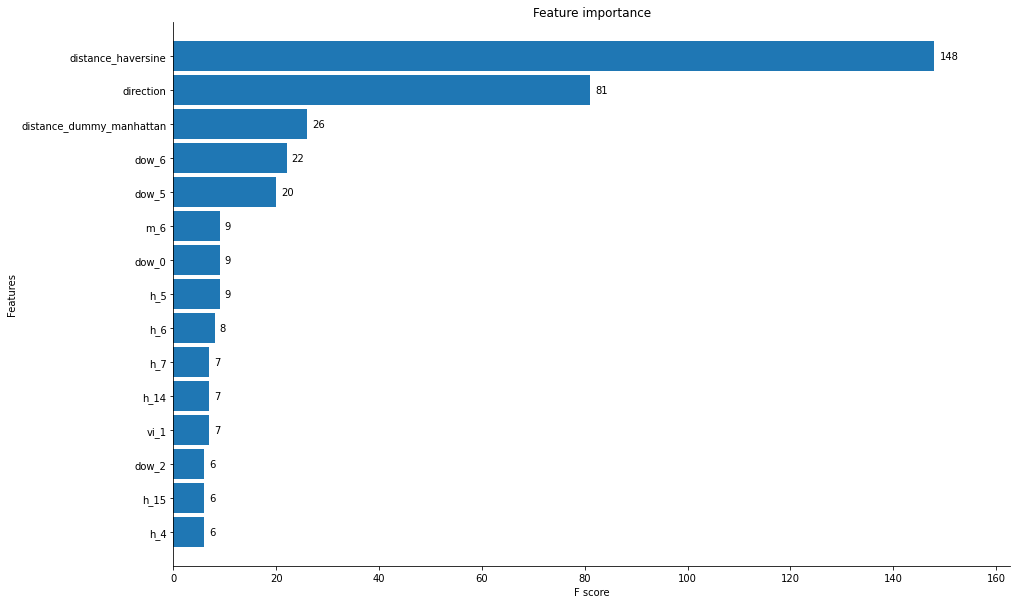

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))

xgb.plot_importance(model, max_num_features = 15, height = 0.9, ax = ax, grid = False)

sns.despine()

From the top-down, we're seeing which features have the greatest effect on trip duration. It makes sense that (haversine) distance has the greatest effect since the further you're going, the longer it'll take to get there.

Now let's make our predictions using the trained model: